<a href="https://colab.research.google.com/github/nedokormysh/GB_Libraries_python_for_DS_2/blob/CourseProject/CourseworkDirtyDrop%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Подключение библиотек и загрузка данных<a class="anchor" id="load_data"></a>

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 7.9 MB/s 


In [2]:
import pandas as pd
import numpy as np
import pickle


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from scipy.stats import chi2_contingency
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler

from scipy.stats import shapiro, probplot, mannwhitneyu

In [3]:
"""Отчет с метриками модели"""
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_displot(feature, data, title, figsize):
    """Диаграмма распределения признака со средней, медианой и модой"""
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    sns.displot(data[feature], bins=40, aspect=figsize[0], height=figsize[1], kde=True)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()

In [5]:
def show_boxplot(feature):
  """Боксплот"""
  plt.figure(figsize=(6, 4))

  sns.boxplot(x=df_train[feature], whis=1.5, orient='h')

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
TRAIN_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_train.csv'
TEST_DATASET_PATH = 'https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/course_project_test.csv'




# output
PREP_DATASET_PATH = 'training_project_data_prep.csv'

TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
VALID_PART_PATH = 'training_project_valid_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'

#**Построение модели классификации**

## 1. Обзор обучающего датасета.

In [29]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
# df_train.columns = [x.replace(" ", "_") for x in df_train.columns]
df_train_base = df_train.copy()
df_train.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


Проверка на дубликаты.

In [ ]:
df_train.duplicated().value_counts()

False    7500
dtype: int64

Общая информация о датасете.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Существуют пропуски 

1.   Bankruptcies
2.   Credit_Score
3.   Years_in_current_job
4.   Annual_Income
5.   Months_since_last_delinquent



In [ ]:
# print(f'В обучающейм датафрейме {df_train.shape[0]} строк и {df_train.shape[1]} столбцов')

**Признаки датасета.**

In [ ]:
# nl = '\n'
# print(f"Названия столбцов в обучающем датафрейме: {nl}{df_train.columns}")

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [ ]:
target = 'Credit Default'

num_feat = list(df_train.select_dtypes(exclude='object').columns)
nom_feat = list(df_train.select_dtypes(include='object').columns)
print(f'Числовые признаки: {num_feat}')
print(f'Номинативные признаки: {nom_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки: ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']
Номинативные признаки: ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
Целевая переменная: Credit Default


### Обзор целевой переменной

Распределение значений целевой переменной

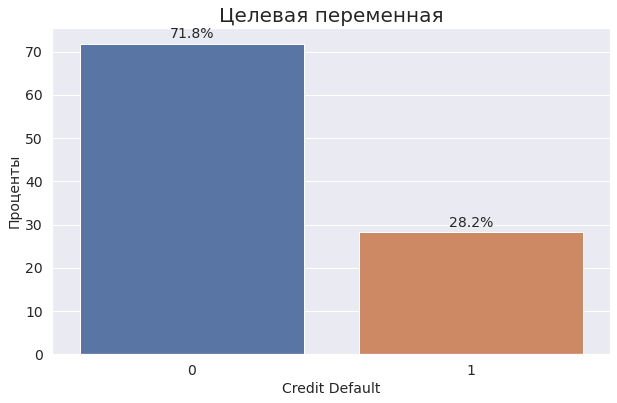

In [ ]:
# нормирование на размер датасета
norm_target = (df_train['Credit Default'].value_counts(normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Целевая переменная', fontsize=20)

plt.xlabel('Credit Default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать. Определим дисбаланс целевой переменной. Будем использовать при построении модели.

In [30]:
disbalance = df_train['Credit Default'].value_counts()[0] / df_train['Credit Default'].value_counts()[1]
disbalance

2.549455750118315

Определим степень влияния признаков на целевой класс

Text(0.5, 1.0, 'Correlation with TARGET variable')

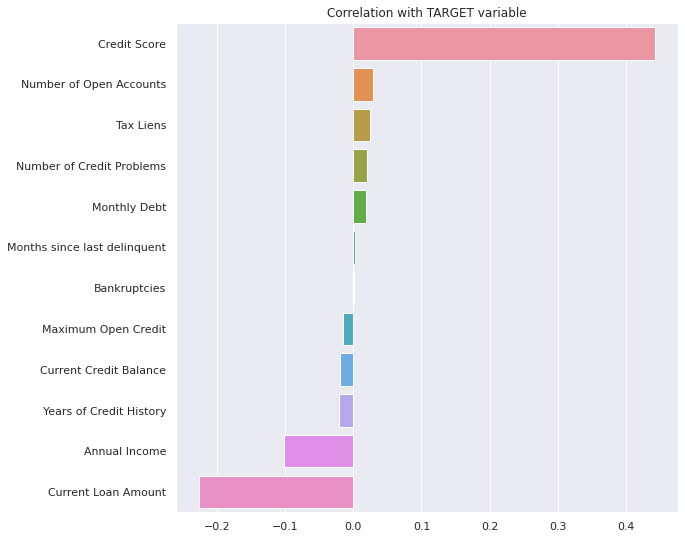

In [ ]:
sns.set(font_scale=1)
corr_with_TARGET = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')

Наибольшая линейная корреляция с целевой переменной наблюдается с Credit_Score и Current_Loan_Amount.

### Номинативные признаки.

In [ ]:
nl = '\n'

def nom_feat_value_counts(nom_feat):
  for el in range(0, len(nom_feat)):
    print('\033[1m' + f'Уникальные значения номинативного признака {nom_feat[el]}:{nl * 2}'
     + '\033[0m' + f'{df_train[nom_feat[el]].value_counts()}{nl}')
    print('-' * 80)

nom_feat_value_counts(nom_feat)

Уникальные значения номинативного признака Home Ownership:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Years in current job:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

--------------------------------------------------------------------------------
Уникальные значения номинативного признака Purpose:

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
weddi

Заменим номинативный признак Years_in_current_job на числовые значения для удобства.

In [ ]:
years_job_dict = {'< 1 year': 0,
                  '1 year': 1,
                  '2 years': 2,
                  '3 years': 3,
                  '4 years': 4,
                  '5 years': 5,
                  '6 years': 6,
                  '7 years': 7,
                  '8 years': 8,
                  '9 years': 9,
                  '10+ years': 10}

df_train['Years in current job'] = pd.Series(df_train['Years in current job'].map(years_job_dict), dtype='int8')

Признак Term принимает всего два значения. Заменим их на 0 и 1.

In [ ]:
term_dict = {'Short Term': 0, 'Long Term': 1}

df_train.Term = pd.Series(df_train.Term.map(term_dict), dtype='int8')

In [ ]:
target = 'Credit Default'
feat =  df_train.columns.drop(target).tolist()
num_feat = list(df_train.select_dtypes(exclude='object').columns.drop([target, 'Term', 'Years in current job']))
cat_feat = list(df_train.select_dtypes(include='object').columns)
print(f'Числовые признаки c целевой переменной: {num_feat}')
print(f'Категориальные признаки: {cat_feat}')
print(f'Целевая переменная: {target}')

Числовые признаки c целевой переменной: ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
Категориальные признаки: ['Home Ownership', 'Purpose']
Целевая переменная: Credit Default


### Числовые признаки.

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Years in current job,7129.0,5.880348e+00,3.620092e+00,0.0,3.0,6.0,10.00,1.000000e+01
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Term,7500.0,2.592000e-01,4.382248e-01,0.0,0.0,0.0,1.00,1.000000e+00



*   Annual_Income - есть пропущенные значения
*   Years_in_current_job - есть пропущенные значения
*   Tax_Liens практически все значения - нули
*   Number of Open Accounts - возможно есть выбросы 
*   Years_of_Credit_History - есть выбросы
*   Maximum_Open_Credit - есть нулевые значения, возможно есть выбросы
*   Current_Loan_Amount - возможно есть выбросы
*   Monthly_Debt - возможно есть выбросы
*   Number_of_Credit_Problems - возможно есть выбросы, и много значений - нули
*   Months_since_last_delinquent - много пропущенных значений
*   Bankruptcies - есть пропуски
*   Credit_Score - много пропусков, корелляция с целевой переменной

**Матрица корреляции между признаками.**

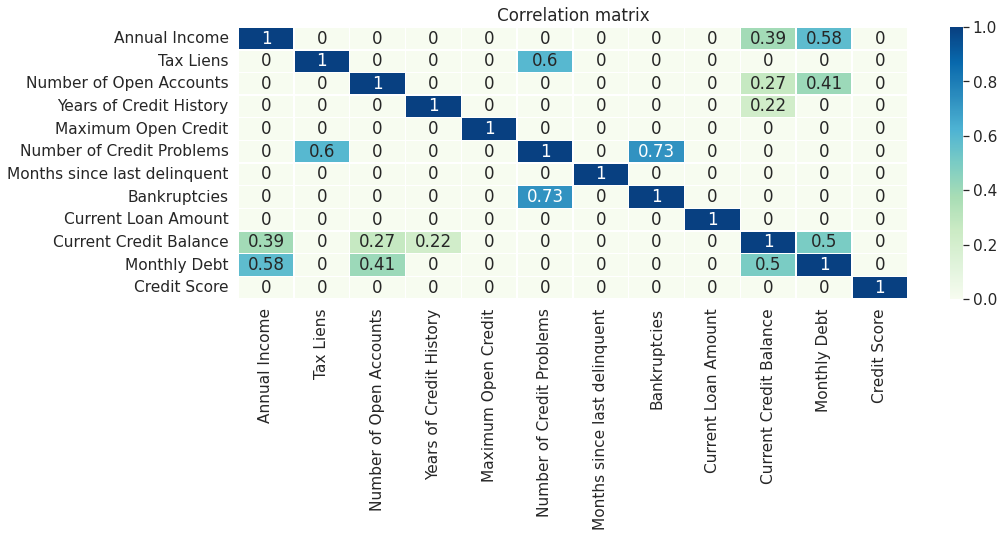

In [ ]:
plt.figure(figsize=(15, 5))

sns.set(font_scale=1.4)

corr_matrix = df_train[num_feat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наблюдаются корреляции между:
*  количеством проблемных кредитов и банкротствами (Number_of_Credit_Problems и Bankruptcies) - 0.73
*  количеством проблемных кредитов и налоговыми обременениями (Number_of_Credit_Problems и Tax_lies) - 0.6
*  месячной задолженностью и годовым доходом (Annual_income и Monthly_Debt) - 0.58
*  текущим кредитным балансом и ежемесячной задолженностью (Current_Credit_Balance и Monthly_Debt) - 0.5
*  годовым доходом и текущим кредитным балансом (Annual_income и Current_Credit_Balance) - 0.39

## 2. Обработка пропусков.

Визуализируем и рассмотрим все признаки, где отсутсвуют значения.

Text(79.5, 0.5, 'Values')

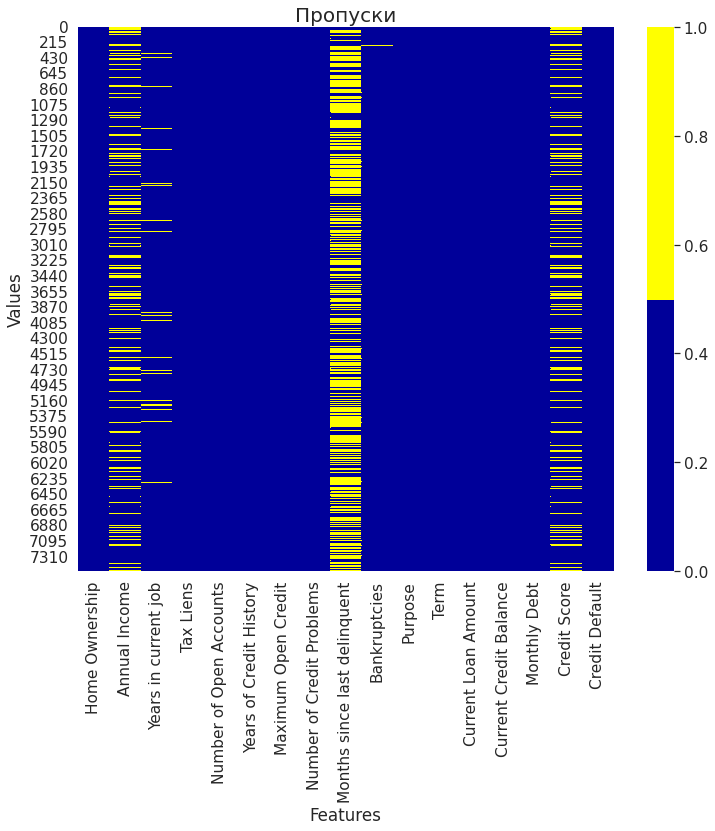

In [ ]:
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные

plt.figure(figsize=(12, 10))
colours = ['#000099', '#ffff00'] 
ax = sns.heatmap(df_train[df_train.columns].isnull(), cmap=sns.color_palette(colours))

# Decorations

plt.title('Пропуски', fontsize=20)

plt.xlabel('Features')
plt.ylabel('Values')

In [ ]:
# df_train.isna().sum()

Найдём процент пропущенных значений.

In [ ]:
print(f'Процент пропусков в датафрейме по столбцам\n')
for col in df_train.columns:
  have_null = df_train[col].isna().sum()
  if have_null != 0:
    print(f'{col} - {round(df_train[col].isna().sum() / df_train.shape[0]*100, 2)}%')

Процент пропусков в датафрейме по столбцам

Annual Income - 20.76%
Years in current job - 4.95%
Months since last delinquent - 54.41%
Bankruptcies - 0.19%
Credit Score - 20.76%


### Annual_Income 

In [ ]:
Annual_Income_med = df_train['Annual Income'].median()
print(f'Медиана признака Annual_Income = {Annual_Income_med}')

Медиана признака Annual_Income = 1168386.0


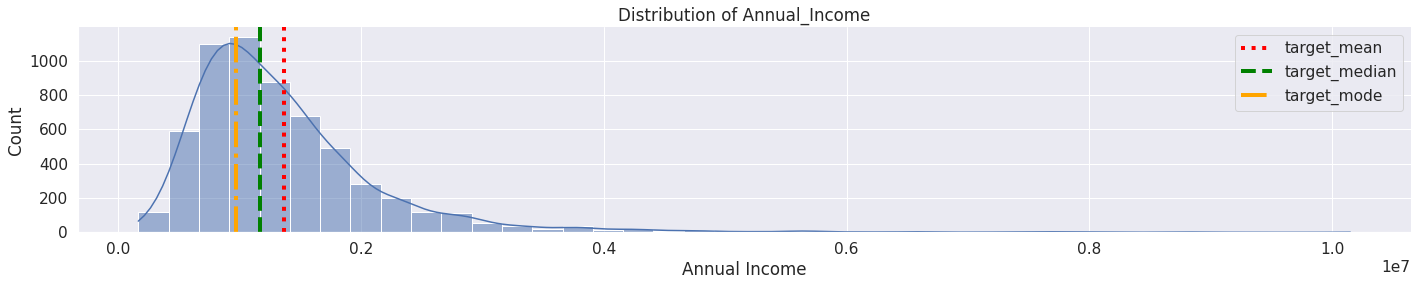

In [ ]:
show_displot(feature='Annual Income', data=df_train, title='Distribution of Annual_Income', figsize=(5, 4))

Введём столбец для учёта тех строк, где были отсутствующие значения.

In [ ]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
# df_train[df_train['Annual_Income_NaN'] == 1].count()

Заполним отсутствующие значения медианой.

In [ ]:
df_train['Annual Income'].fillna(Annual_Income_med, inplace=True)
df_train['Annual Income'].isna().sum()

0

### Years_in_current_job

Заполним пропуски количества лет на работе на значение моды.

In [ ]:
df_train['Years in current job NaN'] = 0
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job NaN'] = 1

In [ ]:
Years_in_current_job_mod = df_train['Years in current job'].mode()[0]
print(f'Мода признака Years_in_current_job = {Years_in_current_job_mod}')

df_train['Years in current job'].fillna(Years_in_current_job_mod, inplace=True)
# print(df_train.Years_in_current_job.isna().sum())

Мода признака Years_in_current_job = 10.0


### Months_since_last_delinquent

Линейная корреляция с целевой переменной мала. Удалим этот признак.

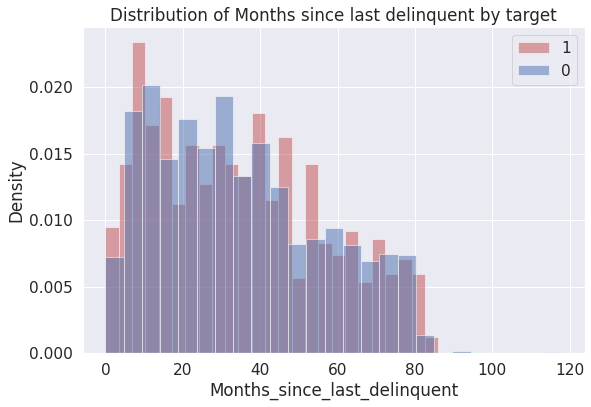

In [ ]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit Default'] == 1, 'Months since last delinquent'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit Default'] == 0, 'Months since last delinquent'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Months_since_last_delinquent')
plt.ylabel('Density')
plt.title('Distribution of Months since last delinquent by target')
plt.legend()
plt.show()

Признак не оказывает сильного влияния на целевую переменную.

### Bankruptcies

Предположим в отсутствующих значениях банкротств, то их просто нет. И заполним значения 0.

In [ ]:
df_train['Bankruptcies NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
df_train['Bankruptcies'].fillna(0 , inplace=True)
# df_train['Bankruptcies'].isna().sum()

### Credit_Score

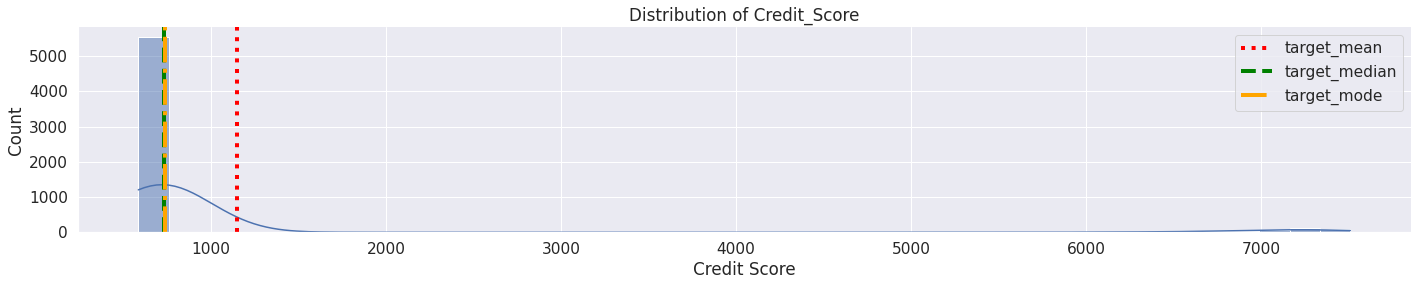

In [ ]:
show_displot(feature='Credit Score', data=df_train, title='Distribution of Credit_Score', figsize=(5, 4))

Заполним отсутствующие значения Credit_Score модой.

In [ ]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1

Credit_Score_mode = df_train['Credit Score'].mode()[0]
Credit_Score_mode

df_train['Credit Score'].fillna(Credit_Score_mode, inplace=True)
df_train['Credit Score'].isna().sum()

0

## Обработка выбросов.

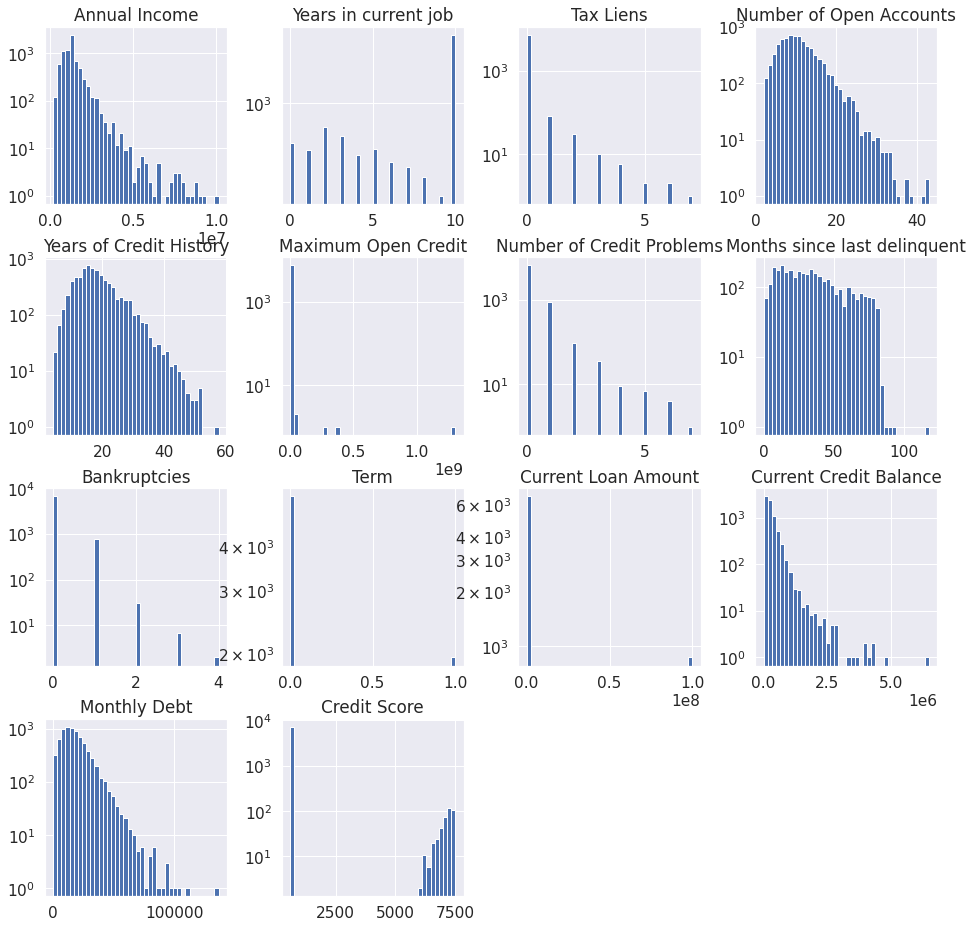

In [ ]:
df_train[feat].hist(bins=40, figsize=(16, 16), log = True)

plt.show()

### Current_Loan_Amount

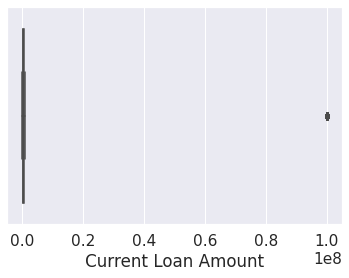

In [ ]:
show_boxplot(feature='Current Loan Amount')

In [ ]:
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'].value_counts()

99999999.0    870
Name: Current Loan Amount, dtype: int64

Наблюдается 870 выбросов со значением 99999999.0. 

Посмотрим на распределение значений в разрезе целевой переменной.

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


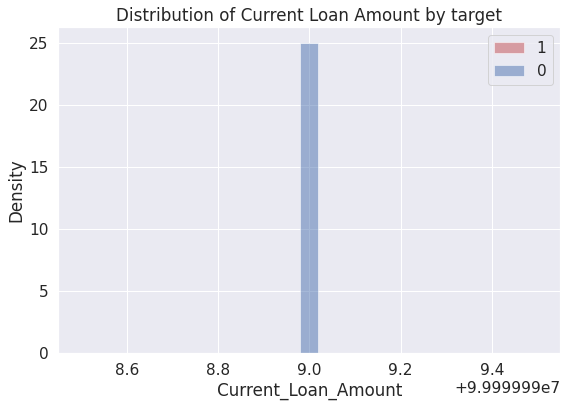

In [ ]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current_Loan_Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

Выбросные значения 99999999.0 имеют значения 0 колонки Credit Default, вероятно, что пользователи с такими значениями не допустили просрочки по кредиту, при этом какой-то кредит возможно есть.

In [ ]:
df_train['Current Loan Amount'].quantile(.95)

99999999.0

Заполним медианой. Хотя возможен вариант заполнения нулём.

In [ ]:
df_train['Current Loan Amount Outlier'] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

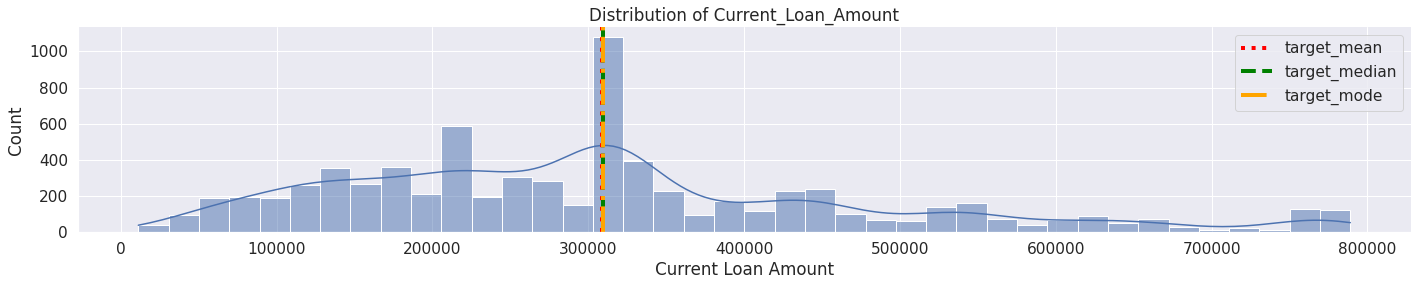

In [ ]:
show_displot(feature='Current Loan Amount', data=df_train, title='Distribution of Current_Loan_Amount', figsize=(5, 4))

### Maximum_Open_Credit

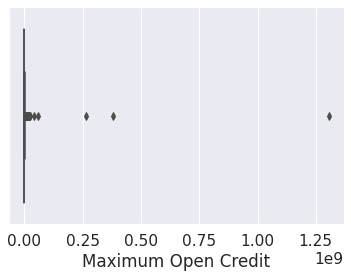

In [ ]:
show_boxplot(feature='Maximum Open Credit')

В Current_Loan_Amount максимальным значением было 99999999.0. Примем его за максимум.

In [ ]:
max_credit = 99999999.0

In [ ]:
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'].count()

3

In [ ]:
df_train['Maximum Open Credit Outlier'] = 0
df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], 'Maximum Open Credit Outlier'] = 1

df_train.loc[df_train['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

Также есть значения, где максимальный кредит меньше размера текущего кредита. Заменим такие значения на Current_Loan_Amount

In [ ]:
df_train.loc[df_train['Maximum Open Credit'] < df_train['Current Loan Amount'], ['Maximum Open Credit', 'Current Loan Amount']].head()

,Maximum Open Credit,Current Loan Amount
8,0.0,129734.0
9,511302.0,572880.0
18,387222.0,553586.0
19,199078.0,309672.0
22,288442.0,309573.0


In [ ]:
for i in range(0, len(df_train['Maximum Open Credit'].values)):
            if df_train['Maximum Open Credit'].values[i] <= df_train['Current Loan Amount'].values[i]:
                df_train['Maximum Open Credit'].values[i] = df_train['Current Loan Amount'].values[i]

### Credit_Score

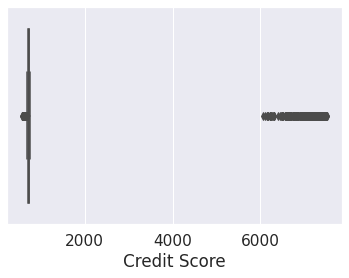

In [ ]:
show_boxplot('Credit Score')

In [ ]:
df_train[df_train['Credit Score'] <= 850]['Credit Score'].count()

7100

In [ ]:
df_train[df_train['Credit Score'] >= 1000]['Credit Score'].count()

400

Есть 400 значений в диапазоне [6000, 8000], которые на порядок больше остальных 7100 в диапазоне [500, 750]. Предположим, что это ошибка и разделим значения более 850 на 10.

In [ ]:
df_train['Credit Score Outlier'] = 0
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] / 10

### Home_Ownership

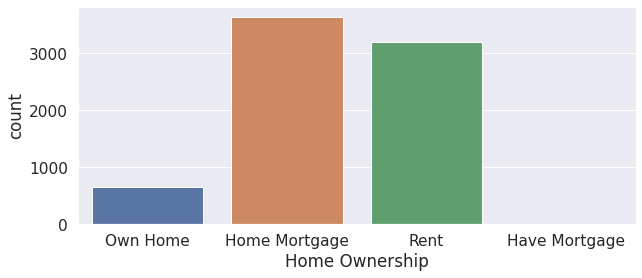

In [ ]:
# Prepare Data
plt.figure(figsize=(10, 4))

# Draw plot
sns.countplot(x=df_train['Home Ownership'])

Home_Ownership - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode().

Have Mortgage - это просто наличие ипотеки. Также как и Home mortgage. Заменим значения на Home mortgage.

In [ ]:
df_train[df_train['Home Ownership'] == 'Have Mortgage']['Home Ownership'].count()

12

In [ ]:
Home_Ownership_mod = df_train['Home Ownership'].mode()[0]
print(f'Мода признака Home_Ownership = {Home_Ownership_mod}')

Мода признака Home_Ownership = Home Mortgage


In [ ]:
df_train['Home Ownership Outlier'] = 0
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership Outlier'] = 1
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = Home_Ownership_mod

### Years_of_Credit_History

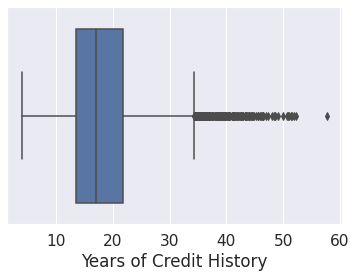

In [ ]:
show_boxplot('Years of Credit History')

In [ ]:
# df_train.Years_of_Credit_History.quantile(0.995)

In [ ]:
df_train[df_train['Years of Credit History'] > 50]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,Annual Income NaN,Years in current job NaN,Bankruptcies NaN,Credit Score NaN,Current Loan Amount Outlier,Maximum Open Credit Outlier,Credit Score Outlier,Home Ownership Outlier
247,Home Mortgage,1893426.0,10.0,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,...,654.0,1,0,1,0,0,0,0,0,0
476,Home Mortgage,1076768.0,10.0,0.0,14.0,57.7,558360.0,0.0,24.0,0.0,...,667.0,1,0,1,0,0,0,1,0,0
3091,Rent,582141.0,10.0,0.0,7.0,50.9,487498.0,0.0,NaN,0.0,...,750.0,0,0,1,0,0,1,0,0,0
3628,Own Home,376314.0,10.0,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,...,720.0,0,0,1,0,0,0,0,0,0
4301,Home Mortgage,1168386.0,10.0,0.0,19.0,51.9,1602524.0,0.0,17.0,0.0,...,740.0,0,1,1,0,1,0,0,0,0
4716,Rent,1168386.0,10.0,0.0,5.0,51.5,614614.0,0.0,14.0,0.0,...,740.0,1,1,1,0,1,0,1,0,0
5673,Home Mortgage,949810.0,10.0,0.0,15.0,50.6,1180388.0,0.0,71.0,0.0,...,727.0,0,0,0,0,0,0,0,0,0
7251,Home Mortgage,1168386.0,10.0,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,...,740.0,1,1,0,0,1,0,0,0,0


In [ ]:
Years_of_Credit_History_mod = df_train['Years of Credit History'].mode()[0]
print(f'Мода Years_of_Credit_History = {Years_of_Credit_History_mod}')

df_train['Years of Credit History Outlier'] = 0
df_train.loc[df_train['Years of Credit History'] > 50, 'Years of Credit History Outlier'] = 1
df_train.loc[df_train['Years of Credit History'] > 50, 'Years of Credit History'] = Years_of_Credit_History_mod

Мода Years_of_Credit_History = 15.0


### Monthly_Debt

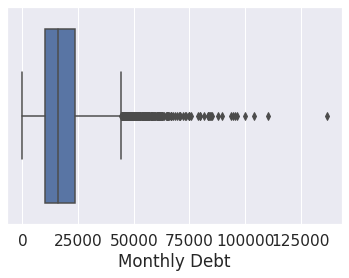

In [ ]:
show_boxplot('Monthly Debt')

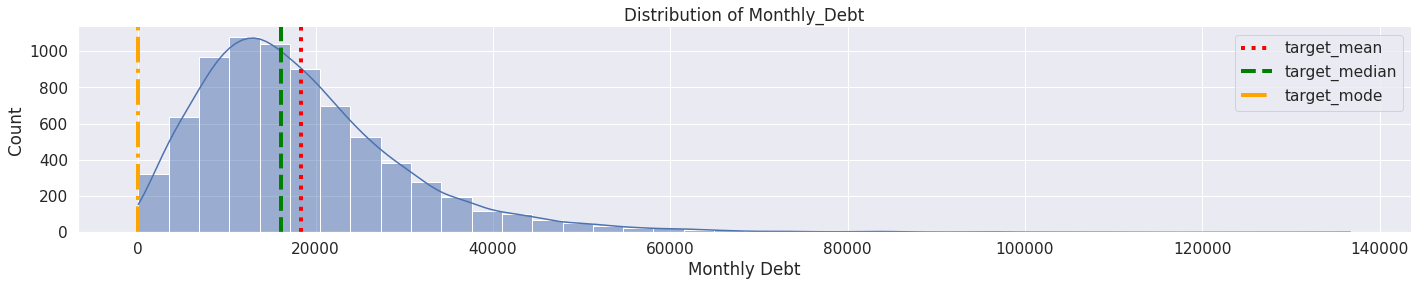

In [ ]:
show_displot(feature='Monthly Debt', data=df_train, title='Distribution of Monthly_Debt', figsize=(5, 4))

In [ ]:
df_train['Monthly Debt'].quantile(0.999)

91718.35100000429

In [ ]:
Monthly_Debt_med = df_train['Monthly Debt'].median()
# print(Monthly_Debt_med)

df_train['Monthly_Debt_Outlier'] = 0
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(0.999), 'Monthly Debt Outlier'] = 1
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(0.999), 'Monthly Debt'] = Monthly_Debt_med

## EDA

### Purpose 

**Оценка признака "Purpose" в разрезе целевой переменной**

В данном признаке слишком много переменных, попробуем их сократить.

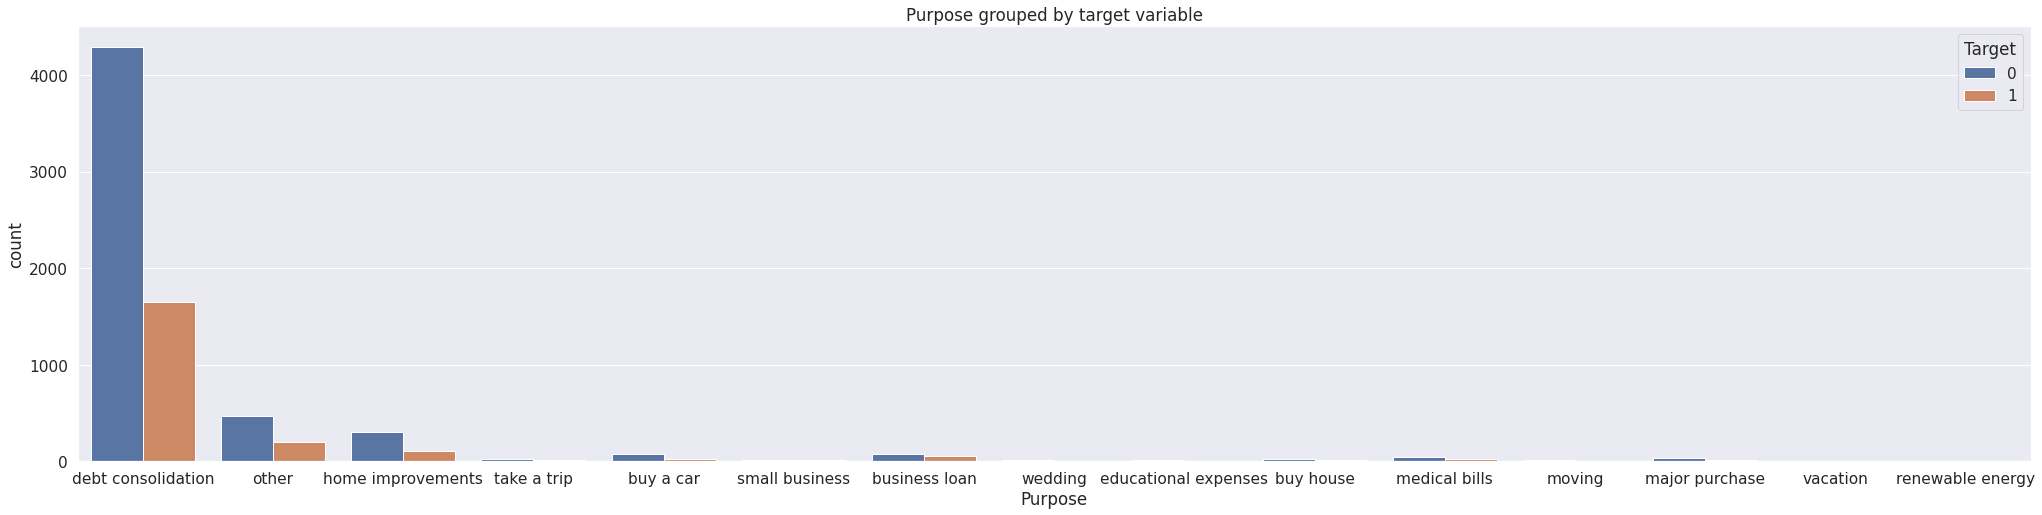

In [ ]:
plt.figure(figsize=(35, 8))

sns.countplot(x="Purpose", hue=target, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
df_train_base['ID'] = df_train_base.index

purpose_target_all = df_train_base[['ID', 'Purpose', 'Credit Default']]

table = purpose_target_all.pivot_table(columns='Credit Default', index='Purpose', values='ID', aggfunc='count')
table.columns.to_list()
table['devide'] = table[0] / table[1]
table

Credit Default,0,1,devide
Purpose,,,
business loan,74.0,55.0,1.345455
buy a car,72.0,24.0,3.000000
buy house,25.0,9.0,2.777778
debt consolidation,4290.0,1654.0,2.593712
educational expenses,9.0,1.0,9.000000
home improvements,304.0,108.0,2.814815
major purchase,31.0,9.0,3.444444
medical bills,49.0,22.0,2.227273
moving,9.0,2.0,4.500000


**Наблюдение**

Проверим гипотезу о согласованности частот в Purpose, используя хи-критерий Пирсона.
Объединим значения по логическим группам и долям в разрезе целевой переменной, рассчитаем таблицы частот и проверим гипотезу для каждой из групп значений

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты выбранных категорий признака Purpose в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [ ]:
business = df_train['Purpose'].isin(['business loan', 'small business'])
purchase = df_train['Purpose'].isin(['buy a car', 'buy house', 'major purchase'])
entertainment = df_train['Purpose'].isin(['vacation', 'wedding', 'take a trip'])
needs = df_train['Purpose'].isin(['debt consolidation', 'home improvements', 'medical bills', 'moving'])
random = df_train['Purpose'].isin(['educational expenses', 'renewable energy', 'other'])

In [ ]:
purpose_business_and_target = df_train_base.loc[business, ['ID', 'Purpose', 'Credit Default']]
purpose_purchase_and_target = df_train_base.loc[purchase, ['ID', 'Purpose', 'Credit Default']]
purpose_entertainment_and_target = df_train_base.loc[entertainment, ['ID', 'Purpose', 'Credit Default']]
purpose_needs_and_target = df_train_base.loc[needs, ['ID', 'Purpose', 'Credit Default']]
purpose_random_and_target = df_train_base.loc[random, ['ID', 'Purpose', 'Credit Default']]

In [ ]:
table_purpose_business_cut = purpose_business_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_business_cut

Credit Default,0,1
Purpose,,
business loan,74,55
small business,12,14


In [ ]:
chi2, p, dof, expected = chi2_contingency(table_purpose_business_cut, correction=False)
p

0.29404148780405304

In [ ]:
table_purpose_purchase_cut = purpose_purchase_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_purchase_cut

Credit Default,0,1
Purpose,,
buy a car,72,24
buy house,25,9
major purchase,31,9


In [ ]:
chi2, p, dof, expected = chi2_contingency(table_purpose_purchase_cut, correction=False)
p

0.9203439570048738

In [ ]:
table_purpose_entertainment_cut = purpose_entertainment_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_entertainment_cut

Credit Default,0,1
Purpose,,
take a trip,27,10
vacation,6,2
wedding,11,4


In [ ]:
chi2, p, dof, expected = chi2_contingency(table_purpose_entertainment_cut, correction=False)
p

0.9931135019442172

In [ ]:
table_purpose_needs_cut = purpose_needs_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table_purpose_needs_cut

Credit Default,0,1
Purpose,,
debt consolidation,4290,1654
home improvements,304,108
medical bills,49,22
moving,9,2


In [ ]:
chi2, p, dof, expected = chi2_contingency(table_purpose_needs_cut, correction=False)
p

0.7112886942093957

In [ ]:
# df_train_base['Purpose'].isna().sum()

In [ ]:
# table_purpose_random_cut = purpose_random_and_target.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
# table_purpose_random_cut

В выбранных категориях P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [ ]:
purpose_change_dict = {'business loan': 'business',
                       'small business': 'business',
                       'buy a car': 'purchase',
                       'buy house': 'purchase',
                       'major purchase': 'purchase',
                       'vacation': 'entertainment',
                       'wedding': 'entertainment',
                       'take a trip': 'entertainment',
                       'debt consolidation': 'needs',
                       'home improvements': 'needs',
                       'medical bills': 'needs',
                       'moving': 'needs',
                       'educational expenses':'educational expenses',
                       'other': 'other',
                       'renewable energy': 'renewable energy'}

df_train['Purpose'] = pd.Series(df_train.Purpose.map(purpose_change_dict))

### Years_in_current_job

Посмотрим на признак 'Years in current job' в разрезе целевой переменной

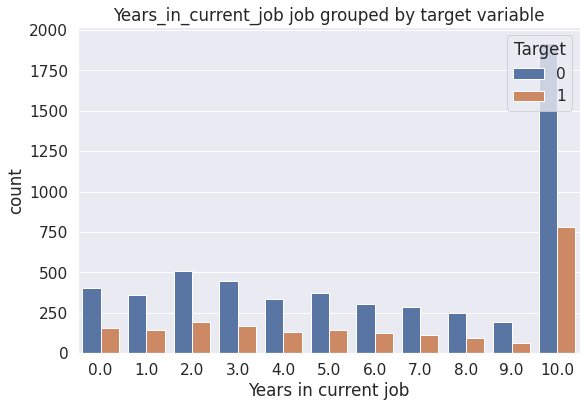

In [ ]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Years in current job', hue='Credit Default', data=df_train)
plt.title('Years_in_current_job job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
df_train.groupby('Years in current job')['Credit Default'].mean().sort_values()

Years in current job
9.0     0.250965
8.0     0.271386
2.0     0.273759
3.0     0.274194
4.0     0.279318
7.0     0.280303
5.0     0.281008
1.0     0.281746
0.0     0.282416
10.0    0.288938
6.0     0.291080
Name: Credit Default, dtype: float64

In [ ]:
df_train['Years in current job'].value_counts()

10.0    2703
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

Years_in_current_job - Создадим разбивку по категориям для лет, проведённых на работе в разделе новых признаков.

### Number of Credit Problems, Bankruptcies

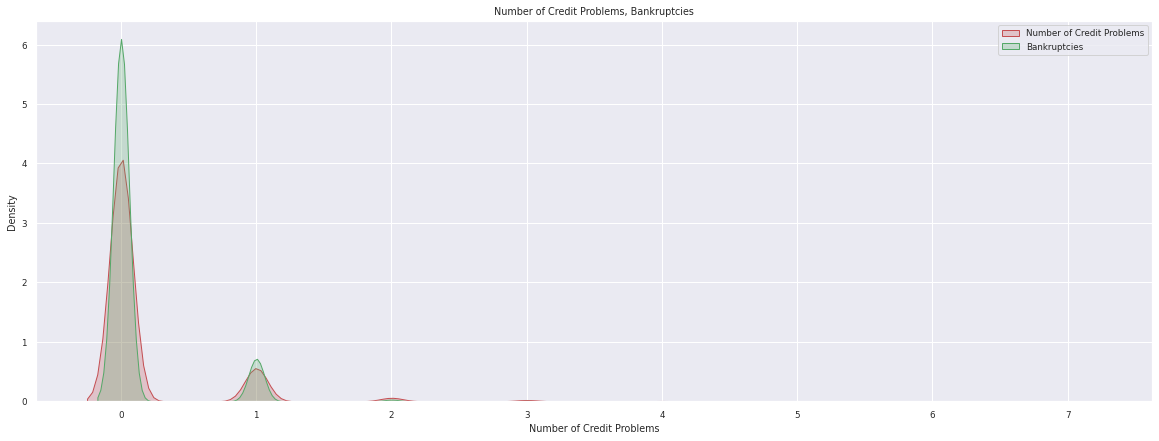

In [ ]:
# train dataset
plt.figure(figsize=(20, 7))
sns.set(font_scale=0.8)
sns.kdeplot(df_train['Number of Credit Problems'], shade=True, label='Number of Credit Problems', color='r')
sns.kdeplot(df_train['Bankruptcies'].fillna(0), shade=True, label='Bankruptcies', color='g')
plt.legend()
plt.title('Number of Credit Problems, Bankruptcies' )
plt.show()

**Наблюдение**

Графики выглядят похожими. 

**Гипотеза**

Нулевая гипотеза: средние значения в двух независимых выборках равны

Альтернативная гипотеза: средние значения в двух независимых выборках различаются

Критерий: критерий Манна-Уитни

Уровень значимости : 0.05

In [ ]:
mannwhitneyu(df_train['Number of Credit Problems'], df_train['Bankruptcies'])

MannwhitneyuResult(statistic=27314833.0, pvalue=4.362140868330774e-08)

Значение p-value оказалось меньше, чем уровень значимости $\alpha$, соответственно. Мы не можем принять нулевую гипотезу

## Добавление новых признаков

### Категории стажа Years_in_current_cat

In [ ]:
df_train['Years in current Cat'] = df_train['Years in current job'].map({0: 0, 
                                                                         1: 0, 
                                                                         2: 0, 
                                                                         3: 0, 
                                                                         4: 1, 
                                                                         5: 1, 
                                                                         5: 1, 
                                                                         7: 2,
                                                                         8: 2,
                                                                         9: 2,
                                                                         10: 3})

### Ежемесячный доход Monthly_Income

In [ ]:
df_train['Monthly Income'] = df_train['Annual Income'] / 12

### Разность ежемесячного дохода и ежемесячной задолженности

In [ ]:
df_train['Monthly Inc Debt Diff'] = df_train['Monthly Income'] - df_train['Monthly Debt']

### Категория кредитного скоринга Credit_Score_category

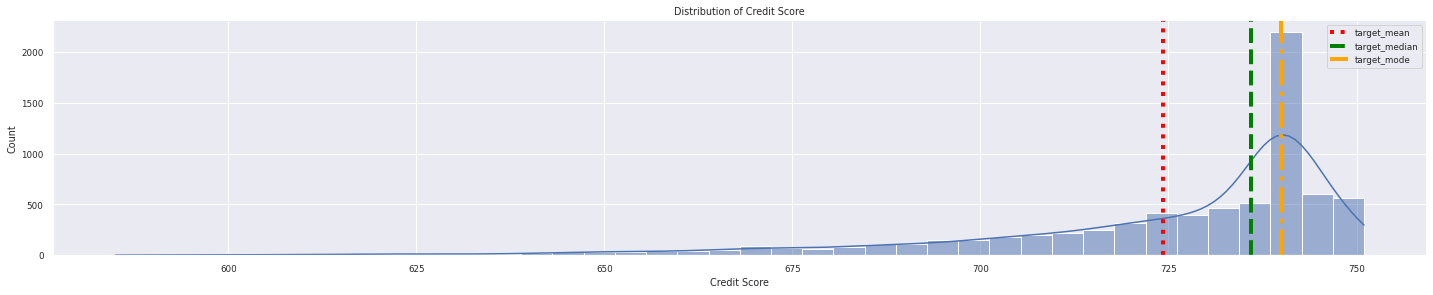

In [ ]:
show_displot(feature='Credit Score', data=df_train, title='Distribution of Credit Score', figsize=(5, 4))

In [ ]:
bins_credit_score = [625, 675, 700, 725, 735, 750]
df_train['Credit Score Cat'] = pd.cut(df_train['Credit Score'], bins=bins_credit_score, labels=False)
df_train['Credit Score Cat'].fillna(-1, inplace=True)

In [ ]:
# df_train.loc[df_train['Credit Score'] <= 625, ['Credit Score', 'Credit Score Cat']]

### Разность между долгом и зарплатой

In [ ]:
df_train['Current Loan and Monthly Income Diff'] = df_train['Current Loan Amount'] - df_train['Monthly Income']

## Классы с обработкой данных

### Preprocessing

In [38]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes=None
        self.max_score = 850
        self.max_credit = 99999999.0
        self.credit_history_mod = 15.0
        self.ownership = 'Home Mortgage'
        self.monthly_debt = 16000
        self.purpose_change_dict = {'business loan': 'business',
                                    'small business': 'business',
                                    'buy a car': 'purchase',
                                    'buy house': 'purchase',
                                    'major purchase': 'purchase',
                                    'vacation': 'entertainment',
                                    'wedding': 'entertainment',
                                    'take a trip': 'entertainment',
                                    'debt consolidation': 'needs',
                                    'home improvements': 'needs',
                                    'medical bills': 'needs',
                                    'moving': 'needs',
                                    'educational expenses':'educational expenses',
                                    'other': 'other',
                                    'renewable energy': 'renewable energy'}
 

        self.years_job_dict = {'< 1 year': 0,
                                 '1 year': 1,
                                 '2 years': 2,
                                 '3 years': 3,
                                 '4 years': 4,
                                 '5 years': 5,
                                 '6 years': 6,
                                 '7 years': 7,
                                 '8 years': 8,
                                 '9 years': 9,
                                 '10+ years': 10}

        
    def fit(self, X):
        """Сохранение статистик"""

        # X.columns = [x.replace(" ", "_") for x in X.columns]
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""

        # Purpose
        X['Purpose'] = pd.Series(X['Purpose'].map(self.purpose_change_dict))

        
        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1

        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.modes['Credit Score'], inplace = True)

     
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']


        # Maximum Open Credit
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] < X['Current Loan Amount'], 'Maximum Open Credit Outlier'] = 1

        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit'] = self.max_credit

        for i in range(0, len(X['Maximum Open Credit'].values)):
            if X['Maximum Open Credit'].values[i] <= X['Current Loan Amount'].values[i]:
                X['Maximum Open Credit'].values[i] = X['Current Loan Amount'].values[i]


        # Annual Income
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)

        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Years_in_current_job   
        X['Years in current job'] = pd.Series(X['Years in current job'].map(self.years_job_dict), dtype='int8')
          
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)


        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(0, inplace=True)


        # Home_Ownership
        X['Home Ownership Outlier'] = 0
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership Outlier'] = 1
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = self.ownership


        # Years_of_Credit_History
        X['Years of Credit History Outlier'] = 0
        X.loc[X['Years of Credit History'] > 50, 'Years of Credit History Outlier'] = 1
        X.loc[X['Years of Credit History'] > 50, 'Years of Credit History'] = self.credit_history_mod

        
        # Term
        X['Term'] = X['Term'].map({'Short Term': 0, 'Long Term': 1}).astype(int)


        X['Monthly Debt Outlier'] = 0
        X.loc[X['Monthly Debt'] > 92000, 'Monthly Debt Outlier'] = 1
        X.loc[X['Monthly Debt'] > 92000, 'Monthly Debt'] = self.monthly_debt

        # Home Ownership, Purpose
        for cat_colname in X.select_dtypes(include='object'):
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
        
                
        X.fillna(self.medians, inplace=True)
        
        return X

### FeatureGenerator

In [39]:
class FeatureGenerator:
    """Генерация новых фич"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # # Term          
        # X.Term = pd.Series(X['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype='int8')


        # Years in current job

        X['Years in current Cat'] = X['Years in current job'].map({0: 0, 
                                                                   1: 0,
                                                                   2: 0,
                                                                   3: 0,
                                                                   4: 1,
                                                                   5: 1,
                                                                   6: 1,
                                                                   7: 2,
                                                                   8: 2,
                                                                   9: 2,
                                                                   10: 3})

        
        # Credit Score
        X = self.credit_score_to_cat(X)


        # Monthly_Income
        X['Monthly Income'] = X['Annual Income'] / 12


        # Monthly_Inc_Debt_Diff
        X['Monthly Inc Debt Diff'] = X['Monthly Income'] - X['Monthly Debt']


        # Current_Loan_and_Monthly_Income_Diff
        X['Current Loan and Monthly Income Diff'] = X['Current Loan Amount'] - X['Monthly Income']

        
        return X
    
    def credit_score_to_cat(self, X):
        bins_credit_score = [625, 675, 700, 725, 735, 750]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins_credit_score, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

In [93]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

df_train.columns.to_list()

preprocessor = DataPreprocessing()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)

df_train.columns.to_list()

features_gen = FeatureGenerator()
features_gen.fit(df_train)
features_gen.transform(df_train)

df_train.columns.to_list()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Credit Score Outlier',
 'Credit Score NaN',
 'Current Loan Amount Outlier',
 'Maximum Open Credit Outlier',
 'Annual Income NaN',
 'Years in current job NaN',
 'Bankruptcies NaN',
 'Home Ownership Outlier',
 'Years of Credit History Outlier',
 'Monthly Debt Outlier',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_educational expenses',
 'Purpose_entertainment',
 'Purpose_needs',
 'Purpose_other',
 'Purpose_purchase',
 'Purpose_renewable energy',
 'Years in current Cat',
 'Credit Score Cat',
 'Monthly Income',
 'Monthly Inc Debt Diff',
 'Current Loan and Monthly Income Diff']

In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        7500 non-null   object 
 1   Annual Income                         7500 non-null   float64
 2   Years in current job                  7500 non-null   int8   
 3   Tax Liens                             7500 non-null   float64
 4   Number of Open Accounts               7500 non-null   float64
 5   Years of Credit History               7500 non-null   float64
 6   Maximum Open Credit                   7500 non-null   float64
 7   Number of Credit Problems             7500 non-null   float64
 8   Bankruptcies                          7500 non-null   float64
 9   Purpose                               7500 non-null   object 
 10  Term                                  7500 non-null   int64  
 11  Current Loan Amou

## Отбор признаков

In [36]:
feature_names = [ 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',]      

new_feature_names = [ 'Credit Score Outlier',
 'Credit Score NaN',
 'Current Loan Amount Outlier',
 'Maximum Open Credit Outlier',
 'Annual Income NaN',
 'Years in current job NaN',
 'Bankruptcies NaN',
 'Home Ownership Outlier',
 'Years of Credit History Outlier',
 'Monthly Debt Outlier',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_educational expenses',
 'Purpose_entertainment',
 'Purpose_needs',
 'Purpose_other',
 'Purpose_purchase',
 'Purpose_renewable energy',
 'Years in current Cat',
 'Credit Score Cat',
 'Monthly Income',
 'Monthly Inc Debt Diff',
 'Current Loan and Monthly Income Diff']

all_feat = ['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Credit Score Outlier',
 'Credit Score NaN',
 'Current Loan Amount Outlier',
 'Maximum Open Credit Outlier',
 'Annual Income NaN',
 'Years in current job NaN',
 'Bankruptcies NaN',
 'Home Ownership Outlier',
 'Years of Credit History Outlier',
 'Monthly Debt Outlier',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_educational expenses',
 'Purpose_entertainment',
 'Purpose_needs',
 'Purpose_other',
 'Purpose_purchase',
 'Purpose_renewable energy',
 'Years in current Cat',
 'Credit Score Cat',
 'Monthly Income',
 'Monthly Inc Debt Diff',
 'Current Loan and Monthly Income Diff']


                     
target_name = 'Credit Default'

In [37]:
plt.figure(figsize=(21, 10))

sns.set(font_scale=1)

corr_matrix = df_train[all_feat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

KeyError: ignored

<Figure size 1512x720 with 0 Axes>

Отберём признаки

In [40]:
feature_names = [ 
  # 'Home Ownership',
 'Annual Income',
 'Years in current job', 
 'Tax Liens',
 'Number of Open Accounts',
#  'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
#  'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']      



new_feature_names = [ 
  'Credit Score Outlier',
  'Credit Score NaN',
#  'Current Loan Amount Outlier',
#  'Maximum Open Credit Outlier',
  'Annual Income NaN',
#  'Years in current job NaN',
#  'Bankruptcies NaN',
  'Home Ownership Outlier',
#  'Years of Credit History Outlier',
#  'Monthly Debt Outlier',
  'Home Ownership_Home Mortgage',
  'Home Ownership_Own Home',
  'Home Ownership_Rent',
  'Purpose_business',
#  'Purpose_educational expenses',
  'Purpose_entertainment',
  'Purpose_needs',
  'Purpose_other',
  'Purpose_purchase',
#  'Purpose_renewable energy',
  'Years in current Cat',
  'Credit Score Cat',
  'Monthly Income',
  'Monthly Inc Debt Diff',
  'Current Loan and Monthly Income Diff']


cat_feature_names = [ 'Home Ownership',
                      'Purpose' ]

target_name = 'Credit Default'

In [ ]:
# for colname in cat_feature_names:
#     df_train[colname] = pd.Categorical(df_train[colname])
    
# df_train[cat_feature_names].dtypes

In [41]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'] 

In [96]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + new_feature_names

## Нормализация данных

In [88]:
df_train_original = pd.read_csv(TRAIN_DATASET_PATH)


preprocessor = DataPreprocessing()
preprocessor.fit(df_train_original)

df_train_original = preprocessor.transform(df_train_original)

# df_train_original.columns.to_list()

features_gen = FeatureGenerator()
features_gen.fit(df_train_original)
features_gen.transform(df_train_original)

df_train_original.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [89]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)

In [90]:
df = pd.read_csv('https://raw.githubusercontent.com/nedokormysh/GB_Libraries_python_for_DS_2/CourseProject/training_project_data_prep.csv')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        7500 non-null   object 
 1   Annual Income                         7500 non-null   float64
 2   Years in current job                  7500 non-null   int64  
 3   Tax Liens                             7500 non-null   float64
 4   Number of Open Accounts               7500 non-null   float64
 5   Years of Credit History               7500 non-null   float64
 6   Maximum Open Credit                   7500 non-null   float64
 7   Number of Credit Problems             7500 non-null   float64
 8   Bankruptcies                          7500 non-null   float64
 9   Purpose                               7500 non-null   object 
 10  Term                                  7500 non-null   int64  
 11  Current Loan Amou

In [91]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_entertainment,Purpose_needs,Purpose_other,Purpose_purchase,Purpose_renewable energy,Years in current Cat,Credit Score Cat,Monthly Income,Monthly Inc Debt Diff,Current Loan and Monthly Income Diff
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,1.0,needs,...,0,1,0,0,0,3,4.0,40173.916667,32259.916667,269399.083333
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,needs,...,0,1,0,0,0,3,4.0,85457.250000,67084.250000,179510.750000
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,needs,...,0,1,0,0,0,2,4.0,62617.666667,48966.666667,246955.333333
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,needs,...,0,1,0,0,0,1,1.0,67089.000000,55751.000000,54307.000000
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,needs,...,0,1,0,0,0,2,2.0,64688.666667,57508.666667,61151.333333


In [ ]:
# TARGET_NAME = 'Credit Default'
# BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME, 'Months since last delinquent']).tolist()
# NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [86]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [87]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_entertainment,Purpose_needs,Purpose_other,Purpose_purchase,Purpose_renewable energy,Years in current Cat,Credit Score Cat,Monthly Income,Monthly Inc Debt Diff,Current Loan and Monthly Income Diff
0,Own Home,-1.114304,1.075647,-0.110953,-0.026674,26.3,-0.028165,1.664779,2.545732,needs,...,0,1,0,0,0,3,4.0,40173.916667,32259.916667,269399.083333
1,Own Home,-0.396190,1.075647,-0.110953,0.788223,15.3,0.182880,-0.340979,-0.337099,needs,...,0,1,0,0,0,3,4.0,85457.250000,67084.250000,179510.750000
2,Home Mortgage,-0.758385,0.526268,-0.110953,-0.026674,35.0,0.183179,-0.340979,-0.337099,needs,...,0,1,0,0,0,2,4.0,62617.666667,48966.666667,246955.333333
3,Own Home,-0.687478,-0.023111,-0.110953,-0.637847,22.5,-0.257425,1.664779,2.545732,needs,...,0,1,0,0,0,1,1.0,67089.000000,55751.000000,54307.000000
4,Rent,-0.725543,0.526268,-0.110953,0.380774,13.6,-0.155925,1.664779,-0.337099,needs,...,0,1,0,0,0,2,2.0,64688.666667,57508.666667,61151.333333


**Сохранение модели для нормализации данных**

In [47]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

## Разбивка обучающей выборки

### New

In [48]:
X = df[SELECTED_FEATURE_NAMES]
y = df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [49]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [50]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

### Old

Разобьем тренировочный датасет на 2 набора - тренировочный и валидационный

In [63]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)


X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=21)
display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [65]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train) #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


((5250, 35), (2250, 35), (2500, 34))

In [66]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train) #  fit применяем только к X_train, y_train

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((5250, 40), (2250, 40), (2500, 39))

In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 3910 to 7113
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        5250 non-null   object 
 1   Annual Income                         5250 non-null   float64
 2   Years in current job                  5250 non-null   int8   
 3   Tax Liens                             5250 non-null   float64
 4   Number of Open Accounts               5250 non-null   float64
 5   Years of Credit History               5250 non-null   float64
 6   Maximum Open Credit                   5250 non-null   float64
 7   Number of Credit Problems             5250 non-null   float64
 8   Bankruptcies                          5250 non-null   float64
 9   Purpose                               5250 non-null   object 
 10  Term                                  5250 non-null   int64  
 11  Current Loan A

In [ ]:
# def cat_to_cat(df):
#   for colname in cat_feature_names:
#     df[colname] = pd.Categorical(df[colname])
#   return df[cat_feature_names].dtypes

# cat_to_cat(X_train)
# cat_to_cat(X_valid)
# cat_to_cat(df_test)

In [68]:
""" во всех датафреймах оставляем только отобранные в разделе 5 признаки """
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [69]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [70]:
X_train.isna().sum()

Annual Income                           0
Years in current job                    0
Tax Liens                               0
Number of Open Accounts                 0
Maximum Open Credit                     0
Number of Credit Problems               0
Bankruptcies                            0
Term                                    0
Current Loan Amount                     0
Current Credit Balance                  0
Monthly Debt                            0
Credit Score                            0
Credit Score Outlier                    0
Credit Score NaN                        0
Annual Income NaN                       0
Home Ownership Outlier                  0
Home Ownership_Home Mortgage            0
Home Ownership_Own Home                 0
Home Ownership_Rent                     0
Purpose_business                        0
Purpose_entertainment                   0
Purpose_needs                           0
Purpose_other                           0
Purpose_purchase                  

### OLD _x

In [97]:
df_train_X = df.copy()
df_test = pd.read_csv(TEST_DATASET_PATH)


X = df_train_X.drop(columns=target_name)
y = df_train_X[target_name]

In [98]:
X_train_X, X_valid_X, y_train_X, y_valid_X = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=21)
display(y_train_X.value_counts(normalize=True), y_valid_X.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [100]:
df_test = preprocessor.transform(df_test)
df_test = features_gen.transform(df_test)

In [101]:
X_train_X = X_train_X[feature_names + new_feature_names]
X_valid_X = X_valid_X[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

## Балансировка признаков

In [ ]:
def balance_df_by_target_over(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
def balance_df_by_target_tomek(df, target_name):

    from imblearn.under_sampling import TomekLinks
    tl = TomekLinks()
    X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
    df = pd.concat([X_tomek, y_tomek], axis=1)

    return df.sample(frac=1)

In [ ]:
def balance_df_by_target_smote(df, target_name):

    from imblearn.over_sampling import SMOTE
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
    df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

Overfitting

In [ ]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target_over(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [ ]:
X_train_balanced = df_balanced.drop(columns=target_name)
y_train_balanced = df_balanced[target_name]

Tomek

Smote

Сохранение.

In [51]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_valid, y_valid], axis=1)

In [ ]:
# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [ ]:
X_train.info()

## Построение модели

In [102]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train_X)
y_test_pred = model_xgb.predict(X_valid_X)

get_classification_report(y_train_X, y_train_pred, y_valid_X, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.99      0.87      3771
           1       0.90      0.31      0.46      1479

    accuracy                           0.80      5250
   macro avg       0.84      0.65      0.67      5250
weighted avg       0.82      0.80      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1616
           1       0.85      0.28      0.42       634

    accuracy                           0.78      2250
   macro avg       0.81      0.63      0.64      2250
weighted avg       0.80      0.78      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1585   31
1                459  175


In [103]:
catb = CatBoostClassifier(silent=True,
                          class_weights=[1, disbalance],
                          random_state=21,
                          custom_metric=['Precision', 'Recall'],
                          eval_metric='F1',
                          )
catb.fit(X_train_X, y_train_X
        #  , cat_features=cat_feature_names
         )

y_train_pred = catb.predict(X_train_X)
y_test_pred = catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3771
           1       0.76      0.89      0.82      1479

    accuracy                           0.89      5250
   macro avg       0.86      0.89      0.87      5250
weighted avg       0.90      0.89      0.89      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.50      0.48      0.49       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1313  303
1                331  303


In [104]:
catb_bal = CatBoostClassifier(silent=True,
                          class_weights=[1, disbalance],
                          random_state=21,
                          custom_metric=['Precision', 'Recall'],
                          eval_metric='F1',
                          )
catb.fit(X_train_balanced, y_train_balanced, cat_features=cat_feature_names)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

NameError: ignored

In [105]:
%%time

catb = CatBoostClassifier(
#                           use_best_model=True,
                          class_weights=[1, disbalance],
                          silent=True,                           
                          random_state=21, 
                          # cat_features=cat_feature_names
                          )

params = {'learning_rate' : [0.035, 0.03, 0.025, 0.02],
          'max_depth' : [3, 4, 5, 7],
          # 'n_estimators' : [300, 350, 400, 450, 500],
          'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500]
          # 'cat_features': ['cat_feature_names']
          }

GridSearch = GridSearchCV(catb, params, scoring='f1')
GridSearch.fit(X_train, y_train)

GridSearch.best_params_

KeyboardInterrupt: ignored

In [59]:
GridSearch.best_params_

{'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 200}

In [109]:
catb = CatBoostClassifier(
    # learning_rate= 0.02, max_depth= 4, n_estimators= 500,
                          # learning_rate= 0.02, max_depth= 5, n_estimators= 500,
                          learning_rate= 0.03, max_depth= 7, n_estimators= 200,
    silent=True,
                          class_weights=[1, disbalance],
                          random_state=21,
                          custom_metric=['Precision', 'Recall'],
                          eval_metric='F1',
                          )
catb.fit(X_train_X, y_train_X
        #  , cat_features=cat_feature_names
         )

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3771
           1       0.65      0.67      0.66      1479

    accuracy                           0.81      5250
   macro avg       0.76      0.76      0.76      5250
weighted avg       0.81      0.81      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.51      0.51      0.51       634

    accuracy                           0.73      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1308  308
1                308  326
